In [1]:
# 参考网址https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
# 使用CNN Keras 卷积神经网络

# 导入包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
sns.set(style='white', context='notebook', palette='deep')


In [3]:
# 导入数据
train = pd.read_csv('./all/train.csv')
test = pd.read_csv('./all/test.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

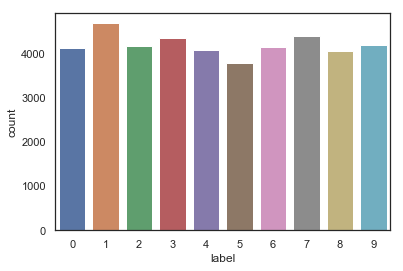

In [4]:
Y_train = train['label']

X_train = train.drop(labels = ['label'], axis=1)

del train

g = sns.countplot(Y_train)
Y_train.value_counts()

In [5]:
# 检查缺失值
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
# 灰度归一化
X_train = X_train / 255.0
test = test / 255.0


In [8]:
# reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [9]:
# 标签独热编码
Y_train = to_categorical(Y_train, num_classes=10)

In [10]:
# 分训练集和验证集
random_seed = 2
X_train , X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)


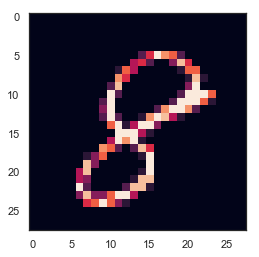

In [11]:
# show examples
g = plt.imshow(X_train[0][:,:,0])

In [12]:
# 搭建CNN网络
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', 
                 input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [13]:
# 设置优化器
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# 动态修改学习率 退火算法
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [15]:
epochs=1
batch_size=86

In [16]:
# 数据增强
datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=False,
                             vertical_flip=False)
datagen.fit(X_train)

In [17]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                             epochs=epochs, validation_data=(X_val,Y_val),
                             verbose=2, steps_per_epoch=X_train.shape[0]//batch_size,
                             callbacks=[learning_rate_reduction])

Epoch 1/1
 - 18s - loss: 0.4039 - acc: 0.8700 - val_loss: 0.0701 - val_acc: 0.9764


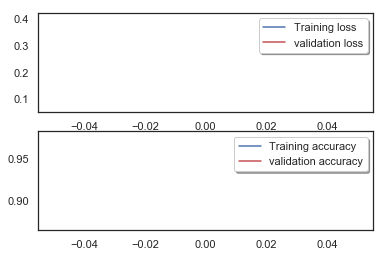

In [18]:
# 画出训练和验证曲线
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'],color='r', label='validation loss', axes=ax[0])
legend = ax[0].legend(loc='best',shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_acc'],color='r', label='validation accuracy')
legend = ax[1].legend(loc='best',shadow=True)


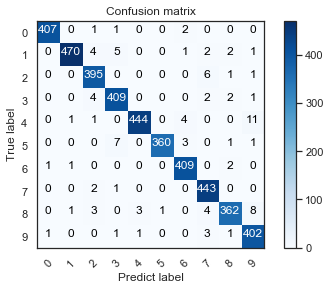

In [24]:
# 混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')
    
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=range(10))

In [20]:
# 预测结果
results = model.predict(test)

results = np.argmax(results, axis=1)

results = pd.Series(results, name="Label")

submission = pd.concat([pd.Series(range(1,28001), name='ImageId'), results], axis=1)

submission.to_csv('cnn_mnist_datagen.csv',index=False)